# Mathematical Model and Optimisation of a Axial-Flux Permanent Magnet Generator

Sources used:

[1] Radwan-Pragłowska N, Węgiel T, Borkowski D. Modeling of Axial Flux Permanent Magnet Generators. Energies. 2020; 13(21):5741. https://doi.org/10.3390/en13215741

[2] Gieras, J.F., & Shen, J.-X. (2022). Modern Permanent Magnet Electric Machines: Theory and Control (1st ed.). CRC Press. https://doi.org/10.1201/9781003103073

[3] Grauers, Anders. (1996). Design of Direct Driven Permanent Magnet Generators for Wind Turbines. 

[4] N42 magnet Br: https://bemagnet.com/n42-magnets/#:~:text=Remanence%3A%20After%20you%20magnetize%20a,strong%20ability%20to%20retain%20magnetism.


In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## General Equations

In [2]:
'''
From [1]
ψ_PM_a        :    Flux of winding 'a' generated by permanent magnets in zero current state (no load)
e_PM_a        :    Generator EMF for winding a at constant speed in zero current state (no load)
ϕ             :    Angle of rotor position with respect to reference frame
Ω             :    Angular velocity
ϑ             :    Power angle
α0            :    Angle of generator EMF
α0L           :    Angle of load voltage

'''



def RPM_2_angvel(RPM):
    return (RPM*2*np.pi/60)

def AFPMG_MODEL(t,y,RPM,L_σs,L_ss,R_stator,R_s,a_mi,ψ_ς_PM,ς):

    i=np.array(y[:3])
    psi=np.array(y[3:])
    
    a_mo = a_mi #assumption! this is for rectangle PM
    
    L = np.array([[L_σs+L_ss,0,0],[0,L_σs+L_ss,0],[0,0,L_σs+L_ss]])

    ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
    
    dψ_PM_1_dt = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi))) * RPM_2_angvel(RPM)
    dψ_PM_2_dt = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi))) * RPM_2_angvel(RPM)
    dψ_PM_3_dt = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi))) * RPM_2_angvel(RPM)
    dψ_PM_dt = np.array([dψ_PM_1_dt,dψ_PM_2_dt,dψ_PM_3_dt])
    
    dψ_PM_1_dpsi = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    dψ_PM_2_dpsi = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    dψ_PM_3_dpsi = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    dψ_PM_dpsi = np.array([dψ_PM_1_dpsi,dψ_PM_2_dpsi,dψ_PM_3_dpsi])
    
    E_G_ph = p * RPM_2_angvel(RPM) * np.sqrt(2) * ψ_PM
    # Check if this is correct;
    # di_dt = np.linalg.solve(L, E_G_ph * np.exp(1j * ((a_mo+a_mi) / 2)/(4 * R_s))- np.dot(R_stator,i) - dψ_PM_dt)
    di_dt = np.linalg.solve(L, E_G_ph - np.dot(R_stator,i) - dψ_PM_dt)
    dpsi_dt= np.array([RPM_2_angvel(RPM)])
    
    return np.concatenate([di_dt,dpsi_dt])

## Model of Coreless Generator with Simple Magnets

In [3]:
'''
From [1]
Constants
µ_0            :    Free spaece permeablilty 
µ_rm           :    Air magnetic permeability
λ_0            :    Constant component for distribution of unit permeability function, =µ_0/(l_δ+2*l'm)

Geometry
r_s            :    0.5*(R_o+R_i)
R_o            :    Outer radius of magnet
R_i            :    Inner radius of magnet
beta           :    0.5*width of magnet at a specific radius. Here, this paper assumes simple PM: beta = (a_mo+a_mi)/(4*r)
l_c            :    =R0-Ri is the magnet length. Note that it has been found that the best is Ri=0.6*Ro
l_c_p          :    l′c approx = Ro-Ri 
l_m            :    height of magnet
l_m_p          :    l'm=lm/µ_rm
l_δ            :    distance between two magnets on both rotors (see Fig 3)

Rotor
Hm             :    magnetic field intensity, ampere turbs per meter unit
B_m            :    Permanent magnet flux density =B_r + mu_0*µ_rm*Hm
a_m            :    =0.5*(a_mo+a_mi), average
a_mo           :    outer radius magnet width
a_mi           :    inner radius magnet width
p              :    Number of magnet/2 (number of pole pairs)

Stator
a_c            :    Distance between winding, average (fig 6)
a_co           :    Distance between widing at outer radius
a_ci           :    Distance between winding at inner radius
a_sc           :    Thickness of winding (fig 6)

Equation
k_e            :    Correction factor for flux weakining at inner and outer magnet edges
B_r_AV         :    Average value of axial component of magnetic flux-density distribution from PM in the middle of the air gap Bm along the coordinate r
B_θ_AV         :    Average value of axial component of magnetic flux-density distribution from PM in the middle of the air gap Bm according to radial coordinate

B_edge         :    value of magnetic flux-density at edge of magnets
B_max          :    maximmum flux-density value
B_ς_PM         :    Foureir coefficients given in euqation (15)
ς              :    is a subset of: Q = {...,-5p,-3p,-p,3p,5p,...}

ψ_ς_PM         :    Coefficients of flux linkages induced by PM
W_ς_S          :    =w_s*k_s_v/|v|
w_s            :    total numbner of turns of stator winding
k_s_v          :    Winding factor for ςth harmnoic
'''


def CorelessGenSimpleMagnet(pmgeovar,statorvar,rotorvar,constants,ς):
    R_o,R_i,l_m,a_mi=pmgeovar
    p,p_s,l_δ=rotorvar
    w_s,a_co,a_ci,a_sc,l_i=statorvar
    µ_0,µ_rm,B_r=constants
    
    #Relations with the assumption that: simple magnet, coreless stator and averaged PM and stator geometry values
    l_c = R_o-R_i
    l_c_p = l_c
    r_s = 0.5*(R_o+R_i)
    a_c=0.5*(a_co+a_ci)
    a_mo = a_mi #assumption! this is for rectangle PM
    
    #Equation
    B_ς_PM=lambda r,ς : ((2*B_r*p)/(np.pi*ς))*np.sin(ς*((a_mo+a_mi)/2)/(4*r))*(2*np.sinh(ς*l_m/r)*np.cosh(ς*(2*l_m+l_δ)/(2*r)))/(µ_rm*np.sinh(ς*(2*l_m+l_δ)/r))
    B_max=np.sum(B_ς_PM(r_s,ς))
    B_edge=0.5*B_max

    B_r_AV = B_max*((l_c - (l_m + l_δ)) / l_c) + B_edge * ((l_m + l_δ) / l_c) + (B_max - B_edge) * (2 / np.pi) * ((l_m + l_δ) / l_c)
    B_θ_AV = np.sum(B_ς_PM(r_s,ς)*np.sin(ς*(((a_mo+a_mi)/2)/(4*r_s)))/(ς*((a_mo+a_mi)/2)/(4*r_s)))

    k_e = B_r_AV/B_θ_AV
    
    k_s_v = lambda r,v : np.sin(abs(v)*a_c/(2*r))*(np.sin(abs(v)*a_sc/(2*r))/(abs(v)*a_sc/(2*r)))
    W_ς_S = w_s*k_s_v(r_s,abs(ς))/abs(ς)
    ψ_ς_PM = 2*k_e*B_ς_PM(r_s,ς)*W_ς_S*r_s*l_c
    
    l_m_p = l_m/µ_rm
    λ_0 = µ_0/(l_δ+2*l_m_p)
    W_v_S=w_s*k_s_v(r_s,p)/abs(p)
    L_ss = (2/np.pi)*(W_v_S**2)*r_s*l_c_p*λ_0
    T_cog = 0
    
    L_σs=2*µ_0*(w_s**2)*(l_c_p+(a_c-a_sc))*0.3/p_s

    return ψ_ς_PM,L_ss,L_σs,T_cog



## All variables


In [4]:
'''
From [1]
Constants
µ_0            :    Free spaece permeablilty 
µ_rm           :    Air magnetic permeability
λ_0            :    Constant component for distribution of unit permeability function, =µ_0/(l_δ+2*l'm)

Geometry
r_s            :    0.5*(R_o+R_i)
R_o            :    Outer radius of magnet
R_i            :    Inner radius of magnet
beta           :    0.5*width of magnet at a specific radius. Here, this paper assumes simple PM: beta = (a_mo+a_mi)/(4*r)
l_c            :    =R0-Ri is the magnet length. Note that it has been found that the best is Ri=0.6*Ro
l_c_p          :    l′c approx = Ro-Ri 
l_m            :    height of magnet
l_m_p          :    l'm=lm/µ_rm
l_δ            :    distance between two magnets on both rotors (see Fig 3)

Rotor
Hm             :    magnetic field intensity, ampere turbs per meter unit
B_m            :    Permanent magnet flux density =B_r + mu_0*µ_rm*Hm
a_m            :    =0.5*(a_mo+a_mi), average
a_mo           :    outer radius magnet width
a_mi           :    inner radius magnet width
p              :    Number of magnet/2 (number of pole pairs)
p_s            :    Number of coils per phase

Stator
a_c            :    Distance between winding, average (fig 6)
a_co           :    Distance between widing at outer radius
a_ci           :    Distance between winding at inner radius
a_sc           :    Thickness of winding (fig 6)
w_s            :    total numbner of turns of stator winding

K&J Magnetics Demagnetization Curves for Grade N35 Neodymium Magnets

Temperature: 20°C
H (kOe), B (kGauss)
-12.61, 0.00
-12.47, 9.27
-12.19, 10.30
-11.74, 11.01
-10.88, 11.41
-9.61, 11.68
0.00, 12.10
-8.90, 2.82
-9.71, 1.96
-10.32, 1.30
-10.80, 0.75
-11.28, 0.17
-11.42, 0.00

From Ali Express: 
30 winding vertical, 8 horizontal
Total winding: 240
Rated 3-5A, Copper Wire Gauge should be: SWG 21

Diameter: 0.81mm
'''

#Constants
µ_0 = 4*np.pi*0.0000001
µ_rm = 1.07
#Hm = 899000
#B_m = 2.82
#B_r = B_m-µ_0*µ_rm*Hm
B_r = 1.24 #Reamenance flux density 

#PM Geometry
R_o = 0.085/2
R_i = 0.050/2
l_m = 0.010
a_mi = 0.010

#Stator properties
w_s = 240.0
a_co = 0.01477
a_ci = 0.01477
a_sc = 0.00648
R_stator=2
l_i = 0.016

#Rotor properties
p=12
p_s=3
l_δ = 0.018

'''
Design variable groups
#PM Geometry
#Stator properties
#Rotor properties
'''

Constants=[µ_0,µ_rm,B_r]
PMGeoVars=[R_o,R_i,l_m,a_mi]
StatorVars=[w_s,a_co,a_ci,a_sc,l_i]
RotorVars=[p,p_s,l_δ]

# Design Variables=p,R_o,R_i,

In [5]:
print(R_o)
print(R_i)
print(R_o-R_i)

0.0425
0.025
0.0175


## Coreless, Simple Magnet


### Instantaneous values

C:\Users\Kai Wen Lee\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


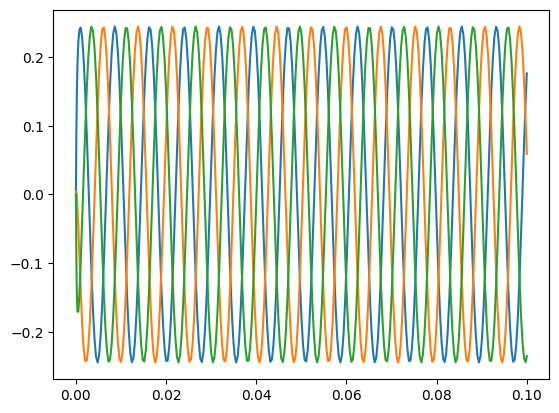

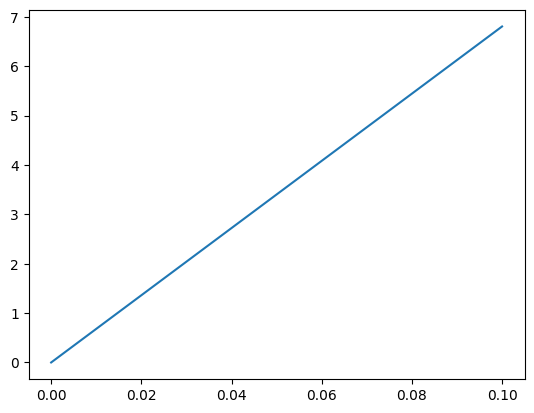

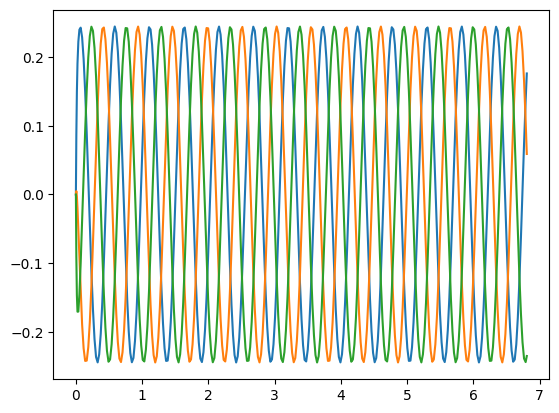

In [6]:
ς = np.array([i * p for i in range(-5, 6) if i != 0 and i % 2 != 0])
ψ_ς_PM, L_ss, L_σs, T_cog = CorelessGenSimpleMagnet(PMGeoVars, StatorVars, RotorVars, Constants,ς)
y0=np.array([0,0,0,0],dtype=np.complex128)

RPM=650

args_=(RPM,L_σs,L_ss,R_stator,(R_o-R_i)/2,a_mi,ψ_ς_PM,ς)
t=solve_ivp(AFPMG_MODEL,[0.0,0.1],y0,args=args_).t
sol=solve_ivp(AFPMG_MODEL,[0.0,0.1],y0,args=args_).y

for i in range(3):
    plt.plot(t,sol[i])

plt.show()

plt.plot(t,sol[3])
plt.show()

for i in range(3):
    plt.plot(sol[3],sol[i])
plt.show()

### Simplified Monoharmonic AFPMG Model in Steady State with Simple Load

In [7]:
'''
From [1]
E_G_ph        :    EMF per phase of generator

ϕ             :    Angle of rotor position with respect to reference frame
Ω             :    Angular velocity
ϑ             :    Power angle

α0            :    Angle of generator EMF
α0L           :    Angle of load voltage

X_S           :    Generator reactance
R_S           :    Generator resistance

X_L           :    Load reactance
R_L           :    Load resistance
L_L           :    Load inductance

I_G           :    Generator phase current
T_em_AV       :    Generator torque per phase
P_el          :    Generator phase power
'''

psi_arr=np.linspace(0,2*np.pi,100)

X_S = p * RPM_2_angvel(RPM) * (L_σs+L_ss)
R_S = R_stator

L_L = 0
X_L =  p * RPM_2_angvel(RPM) * L_L
R_L = 40


X_SL = X_L+X_S
R_SL = R_S + R_L

α0 = np.arctan(X_SL/R_SL)
α0L = np.arctan(X_L/R_L)
ϑ = α0 - α0L

res=[]
for psi in psi_arr:
    ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
    E_G_ph = p*RPM_2_angvel(RPM)*np.sqrt(2)*ψ_PM
    e_j_β0 = np.exp(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2))
    e_j_ϑ_β0 = np.exp(ϑ+(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2)))
    e_j_0 = np.exp(ϑ * 1j)
    
    I_G = (-E_G_ph*e_j_0)/(R_SL+1j*X_SL)
    T_em_AV = (3*(E_G_ph**2)*R_SL)/(RPM_2_angvel(RPM)*(R_SL**2+X_SL**2))
    P_el = 3*R_L*abs(I_G**2)
    
    res.append([E_G_ph,I_G,T_em_AV,P_el])
    
for sublist in res:
    print(sublist[3])

[0.01113395 0.0027839  0.0027839 ]
[0.00583241 0.01025037 0.00061897]
[2.52127032e-05 8.79650387e-03 7.88003743e-03]
[0.00477525 0.00119125 0.01073525]
[0.01103337 0.0019217  0.00374669]
[0.00687996 0.00959625 0.00022555]
[0.00022555 0.00959625 0.00687996]
[0.00374669 0.0019217  0.01103337]
[0.01073525 0.00119125 0.00477525]
[7.88003743e-03 8.79650387e-03 2.52127032e-05]
[0.00061897 0.01025037 0.00583241]
[0.0027839  0.0027839  0.01113395]
[0.01025037 0.00061897 0.00583241]
[8.79650387e-03 7.88003743e-03 2.52127032e-05]
[0.00119125 0.01073525 0.00477525]
[0.0019217  0.00374669 0.01103337]
[0.00959625 0.00022555 0.00687996]
[0.00959625 0.00687996 0.00022555]
[0.0019217  0.01103337 0.00374669]
[0.00119125 0.00477525 0.01073525]
[8.79650387e-03 2.52127032e-05 7.88003743e-03]
[0.01025037 0.00583241 0.00061897]
[0.0027839  0.01113395 0.0027839 ]
[0.00061897 0.00583241 0.01025037]
[7.88003743e-03 2.52127032e-05 8.79650387e-03]
[0.01073525 0.00477525 0.00119125]
[0.00374669 0.01103337 0.00192

## Model of  Generator with Stator Core

## Simple magnet, With Stator Core

In [8]:
def CoreGenSimpleMagnet(pmgeovar,statorvar,rotorvar,constants,ς,M):
    R_o,R_i,l_m,a_mi=pmgeovar
    p,p_s,l_δ=rotorvar
    w_s,a_co,a_ci,a_sc,l_i=statorvar
    µ_0,µ_rm,B_r=constants
    
    #Relations with the assumption that: simple magnet, coreless stator and averaged PM and stator geometry values
    l_c = R_o-R_i
    l_c_p = l_c
    r_s = 0.5*(R_o+R_i)
    a_c=0.5*(a_co+a_ci)
    a_mo = a_mi #assumption! this is for rectangle PM
    
    #Equation
    B_ς_PM=lambda r,ς : ((2*B_r*p)/(np.pi*ς))*np.sin(ς*((a_mo+a_mi)/2)/(4*r))*(2*np.sinh(ς*l_m/r)*np.cosh(ς*(2*l_m+l_δ-l_i)/(2*r)))/(µ_rm*np.sinh(ς*(2*l_m+l_δ-l_i)/r))
    
    '''
    l_m_p = l_m/µ_rm
    W_ςM_S = w_s*k_s_v(r_s,abs(ς+M))/abs(ς+M)
    W_vM_S=w_s*k_s_v(r_s,p)/abs(p)
    '''
    k_s_v = lambda r,v : np.sin(abs(v)*a_c/(2*r))*(np.sin(abs(v)*a_sc/(2*r))/(abs(v)*a_sc/(2*r)))
    W_v_S = lambda r,v : w_s*k_s_v(r,v)/abs(v)
    
    l_m_p = l_m/µ_rm
    λ_max=µ_0/(l_δ-l_i+2*l_m_p)
    λ_min=µ_0/(l_δ+2*l_m_p)
    λ_ref = µ_0/(l_δ+2*l_m_p)
    
    def λ_m(r,m_):
        λ_temp = np.where(m_ == 0, 
                  λ_min + (λ_max - λ_min) * (3 / np.pi) * p_s * ((a_c / r - a_sc / r) / 2),
                  (λ_max - λ_min) * (3 / np.pi) * (p_s / m_) * np.sin(m_ * ((a_c / r - a_sc / r) / 2)))

        return λ_temp
    
    def ψ_ς_PM_(r,V,M):
        ψ_temp = np.array([])
        for v in V:
            c = np.where(M + v == 0, 0, 1)
            W_vM_S_temp = np.where(v + M == 0, 0, W_v_S(r, v + M))  # Define a value for W_v_S when v+M = 0
            temp_=np.sum((2*c*(λ_m(r,M)/λ_ref)*B_ς_PM(r,v)*W_vM_S_temp*r*l_c))
            ψ_temp=np.hstack((temp_,ψ_temp))
            
        return ψ_temp
    
    
    def L_ss_(r,V,M):
        L_ss_temp=np.array([])
        for m in M:
            c = np.where(m + V == 0, 0, 1)
            W_vM_S_temp = np.where(V + m == 0, 0, W_v_S(r, V + m))
            temp_=np.sum((2/np.pi)*c*W_v_S(r,V)*W_vM_S_temp*r*l_c_p*λ_m(r,m))
            L_ss_temp=np.hstack((temp_,L_ss_temp))

        return np.sum(L_ss_temp)
    
    L_ss = L_ss_(r_s,ς,M)
    L_σs=2*µ_0*(w_s**2)*(l_c_p+(a_c-a_sc))*0.3/p_s
    ψ_ς_PM = ψ_ς_PM_(r_s,ς,M)
    T_cog=1
    return ψ_ς_PM,L_ss,L_σs,T_cog



### Instantaneous Values

C:\Users\Kai Wen Lee\AppData\Local\Temp\ipykernel_9092\1309748449.py:22: RuntimeWarning: invalid value encountered in divide
  k_s_v = lambda r,v : np.sin(abs(v)*a_c/(2*r))*(np.sin(abs(v)*a_sc/(2*r))/(abs(v)*a_sc/(2*r)))
C:\Users\Kai Wen Lee\AppData\Local\Temp\ipykernel_9092\1309748449.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  (λ_max - λ_min) * (3 / np.pi) * (p_s / m_) * np.sin(m_ * ((a_c / r - a_sc / r) / 2)))
C:\Users\Kai Wen Lee\AppData\Local\Temp\ipykernel_9092\1309748449.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  (λ_max - λ_min) * (3 / np.pi) * (p_s / m_) * np.sin(m_ * ((a_c / r - a_sc / r) / 2)))
C:\Users\Kai Wen Lee\AppData\Local\Temp\ipykernel_9092\1309748449.py:33: RuntimeWarning: divide by zero encountered in divide
  (λ_max - λ_min) * (3 / np.pi) * (p_s / m_) * np.sin(m_ * ((a_c / r - a_sc / r) / 2)))
C:\Users\Kai Wen Lee\AppData\Local\Temp\ipykernel_9092\1309748449.py:33: RuntimeWarning: invalid value encountered in mult

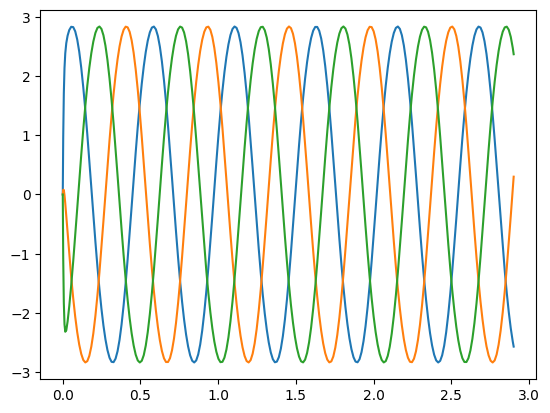

[ 0.1724095 +7.68535847e-37j -0.08621119+0.00000000e+00j
 -0.08621119+0.00000000e+00j]


In [9]:
ς = np.array([i * p for i in range(-5, 6) if i != 0 and i % 2 != 0])
M = np.array([i * 3 * p for i in range(-3, 4)])

ψ_ς_PM, L_ss, L_σs, T_cog = CoreGenSimpleMagnet(PMGeoVars, StatorVars, RotorVars, Constants,ς,M)

y0=np.array([0,0,0,0],dtype=np.complex128)

RPM=277

args_=(RPM,L_σs,L_ss,R_stator,(R_o-R_i)/2,a_mi,ψ_ς_PM,ς)
t=solve_ivp(AFPMG_MODEL,[0.0,0.1],y0,args=args_).t
sol=solve_ivp(AFPMG_MODEL,[0.0,0.1],y0,args=args_).y

for i in range(3):
    plt.plot(sol[3],sol[i])

plt.show()

E_G_ph = p * RPM_2_angvel(RPM) * np.sqrt(2) * ψ_PM
print(E_G_ph)

C:\Users\Kai Wen Lee\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


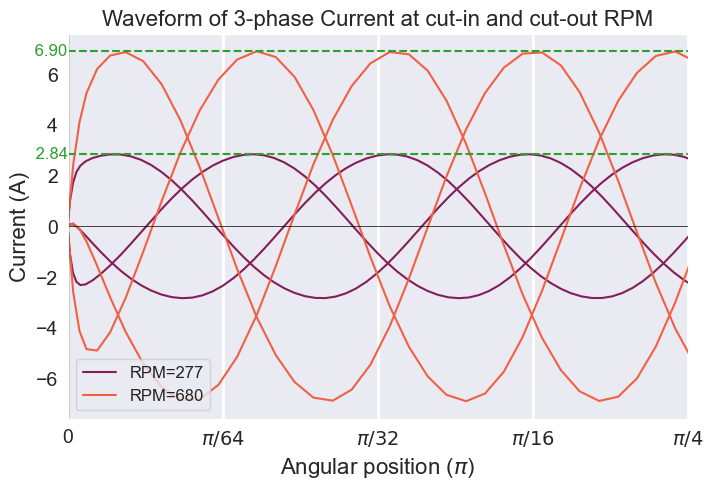

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import solve_ivp

# Define your functions here (CoreGenSimpleMagnet, AFPMG_MODEL, RPM_2_angvel, etc.)

# Define the parameters
RPM_values = [277, 680]
y0 = np.array([0, 0, 0, 0], dtype=np.complex128)
t_span = [0.0, 0.1]

# Set Seaborn style
sns.set_style("darkgrid")

# Plot settings
plt.figure(figsize=(8, 5))

# Define colors for different RPMs
colors = sns.color_palette("rocket", len(RPM_values))

# Initialize a list to store maximum currents for each RPM
max_currents = []

# Loop over RPM values
for i, RPM in enumerate(RPM_values):
    args_ = (RPM, L_σs, L_ss, R_stator, (R_o - R_i) / 2, a_mi, ψ_ς_PM, ς)
    t = solve_ivp(AFPMG_MODEL, t_span, y0, args=args_).t
    sol = solve_ivp(AFPMG_MODEL, t_span, y0, args=args_).y
    
    # Calculate maximum current for the current RPM
    max_current = np.max(np.abs(sol[0]))
    max_currents.append(max_current)
    
    # Plot waveforms with different shades of the same color
    for j in range(3):
        plt.plot(sol[3], sol[j], color=colors[i], label=f'RPM={RPM}' if j == 0 else None)

# Add labels and title
plt.xlabel('Angular position ($\\pi$)', fontsize=16)
plt.ylabel('Current (A)', fontsize=16)
plt.title('Waveform of 3-phase Current at cut-in and cut-out RPM', fontsize=16)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=1)

# Set x-tick labels in terms of pi
plt.xticks(np.linspace(0, 0.25 * np.pi, 5), ['0', '$\\pi/64$', '$\\pi/32$', '$\\pi/16$', '$\\pi/4$'], fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 0.25 * np.pi])

# Plot dashed lines indicating maximum currents
for max_current in max_currents:
    plt.axhline(y=max_current, color=sns.color_palette()[2], linestyle='--')  # Match color with Seaborn theme
    plt.text(0, max_current, f' {max_current:.2f}', ha='right', va='center', fontsize=12, color=sns.color_palette()[2])

# Add legend for each RPM
plt.legend(fontsize=12)

# Adjust grid line width
# Remove horizontal grid lines
plt.grid(linewidth=2)
plt.grid(False, axis='y')

# Show the plot
plt.savefig('waveform.png', dpi=300)  # Increase DPI for higher resolution
plt.show()


In [11]:
'''
From [1]
E_G_ph        :    EMF per phase of generator

ϕ             :    Angle of rotor position with respect to reference frame
Ω             :    Angular velocity
ϑ             :    Power angle

α0            :    Angle of generator EMF
α0L           :    Angle of load voltage

X_S           :    Generator reactance
R_S           :    Generator resistance

X_L           :    Load reactance
R_L           :    Load resistance
L_L           :    Load inductance

I_G           :    Generator phase current
T_em_AV       :    Generator torque per phase
P_el          :    Generator phase power

psi_arr=np.linspace(0,2*np.pi,100)

X_S = p * RPM_2_angvel(RPM) * (L_σs+L_ss)
R_S = R_stator

L_L = 0
X_L =  p * RPM_2_angvel(RPM) * L_L
R_L = 2


X_SL = X_L+X_S
R_SL = R_S + R_L

α0 = np.arctan(X_SL/R_SL)
α0L = np.arctan(X_L/R_L)
ϑ = α0 - α0L

res=[]
for psi in psi_arr:
    ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
    E_G_ph = p*RPM_2_angvel(RPM)*np.sqrt(2)*ψ_PM
    e_j_β0 = np.exp(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2))
    e_j_ϑ_β0 = np.exp(ϑ+(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2)))
    e_j_0 = np.exp(ϑ * 1j)

    I_G = (-E_G_ph*e_j_0)/(R_SL+1j*X_SL)
    T_em_AV = (3*(E_G_ph**2)*R_SL)/(RPM_2_angvel(RPM)*(R_SL**2+X_SL**2))
    P_el = 3*R_L*abs(I_G**2)

    res.append([E_G_ph,I_G,T_em_AV,P_el])
'''
    
def getPowerRPM(RPM, R_L=2,opt=1):
    psi_arr=np.linspace(0,2*np.pi,100)

    X_S = p * RPM_2_angvel(RPM) * (L_σs+L_ss)
    R_S = R_stator

    L_L = 0
    X_L =  p * RPM_2_angvel(RPM) * L_L
    R_L = R_L


    X_SL = X_L+X_S
    R_SL = R_S + R_L

    α0 = np.arctan(X_SL/R_SL)
    α0L = np.arctan(X_L/R_L)
    ϑ = α0 - α0L

    res=[]
    for psi in psi_arr:
        ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
        E_G_ph = p*RPM_2_angvel(RPM)*np.sqrt(2)*ψ_PM
        e_j_β0 = np.exp(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2))
        e_j_ϑ_β0 = np.exp(ϑ+(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2)))
        e_j_0 = np.exp(ϑ * 1j)

        I_G = (-E_G_ph*e_j_0)/(R_SL+1j*X_SL)
        T_em_AV = (3*(E_G_ph**2)*R_SL)/(RPM_2_angvel(RPM)*(R_SL**2+X_SL**2))
        P_el = 3*R_L*abs(I_G**2)
        
        P_RMS=np.sqrt(np.mean(P_el ** 2))
        P_max=np.max(P_el)

        #res.append([E_G_ph,I_G,T_em_AV,P_el])
        if opt ==1:
            output=P_RMS
        else:
            output=P_max
        return output

def getEMFRPM(RPM):
    psi_arr=np.linspace(0,2*np.pi,100)
    for psi in psi_arr:
        ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
        E_G_ph = p*RPM_2_angvel(RPM)*np.sqrt(2)*ψ_PM
    
    return np.sqrt(np.mean(E_G_ph ** 2))

def getTorqueCurrent(RPM, R_L=2,opt=1):
    psi_arr=np.linspace(0,2*np.pi,100)

    X_S = p * RPM_2_angvel(RPM) * (L_σs+L_ss)
    R_S = R_stator

    L_L = 0
    X_L =  p * RPM_2_angvel(RPM) * L_L
    R_L = R_L


    X_SL = X_L+X_S
    R_SL = R_S + R_L

    α0 = np.arctan(X_SL/R_SL)
    α0L = np.arctan(X_L/R_L)
    ϑ = α0 - α0L

    I_G_values = []
    T_em_AV_values = []
    for psi in psi_arr:
        ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
        ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
        E_G_ph = p*RPM_2_angvel(RPM)*np.sqrt(2)*ψ_PM
        e_j_β0 = np.exp(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2))
        e_j_ϑ_β0 = np.exp(ϑ+(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2)))
        e_j_0 = np.exp(ϑ * 1j)

        I_G = (-E_G_ph*e_j_0)/(R_SL+1j*X_SL)
        T_em_AV = (3*(E_G_ph**2)*R_SL)/(RPM_2_angvel(RPM)*(R_SL**2+X_SL**2))
        P_el = 3*R_L*abs(I_G**2)
        '''
        I_G_values.append(np.sqrt(np.mean(I_G ** 2)))
        T_em_AV_values.append(np.sqrt(np.mean(T_em_AV ** 2)))
        '''
        I_G_values.append(np.sqrt(np.mean(np.real(I_G) ** 2)))
        T_em_AV_values.append(np.sqrt(np.mean(np.real(T_em_AV) ** 2)))

    # Accumulate the values for each RPM value
    I_G_accumulated = np.mean(I_G_values)
    T_em_AV_accumulated = np.mean(T_em_AV_values)

    return I_G_accumulated, T_em_AV_accumulated

## Plots needed:

1. Power - RPM at specific load
2. Voltage - RPM at no current conditions
3. Torque - Current


### Power - RPM 

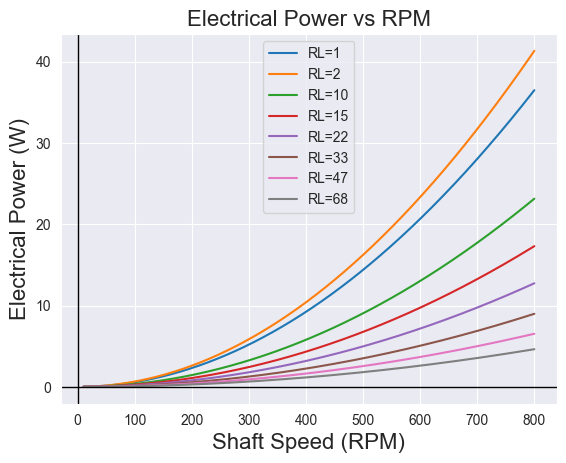

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

minRPM=10
maxRPM=800
# Define a range of RPM values
RPM_values = np.linspace(10, maxRPM, 1000)
RL_values = [1,2,10,15,22,33,47,68]

# Calculate P_el for each RPM value and each RL value
P_el_values = []
for RL in RL_values:
    P_el_RMS = [getPowerRPM(RPM, RL) for RPM in RPM_values]
    P_el_values.append(P_el_RMS)

# Save data as CSV (optional)
data = np.column_stack((RPM_values, *P_el_values))
np.savetxt('power_data_rms.csv', data, delimiter=',', header='RPM,' + ','.join([f'RPMS Power (RL={RL})' for RL in RL_values]), comments='')

# Set Seaborn style
sns.set_style("darkgrid")

# Plot P_el against RPM for each RL value
for RL, P_el_RMS in zip(RL_values, P_el_values):
    plt.plot(RPM_values, P_el_RMS, label=f'RL={RL}')

plt.xlabel('Shaft Speed (RPM)',fontsize=16)
plt.ylabel('Electrical Power (W)',fontsize=16)
plt.title('Electrical Power vs RPM',fontsize=16)
plt.legend()
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.savefig('pwr_rpm.png', dpi=300)  # Increase DPI for higher resolution
plt.show()


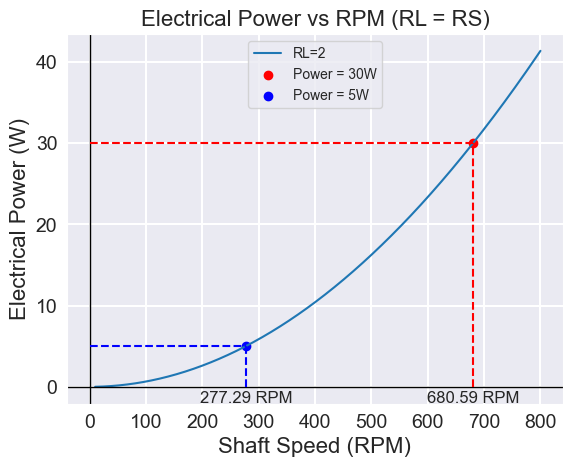

In [13]:
# Define a range of RPM values
RPM_values = np.linspace(10, 800, 1000)
RL_values = R_S

# Calculate P_el for each RPM value and each RL value
P_el_values = []

P_el_RMS = [getPowerRPM(RPM, RL_values) for RPM in RPM_values]
P_el_values.append(P_el_RMS)

# Save data as CSV (optional)
data = np.column_stack((RPM_values, *P_el_values))
# Set Seaborn style
sns.set_style("darkgrid")

plt.plot(RPM_values, P_el_RMS, label=f'RL={RL_values}')

plt.xlabel('Shaft Speed (RPM)',fontsize=16)
plt.ylabel('Electrical Power (W)',fontsize=16)
plt.title('Electrical Power vs RPM (RL = RS)',fontsize=16)
plt.legend()
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
# Increase the width of grid lines

plt.xticks(fontsize=14)  # Enlarge x-axis tick labels font size
plt.yticks(fontsize=14)  # Enlarge y-axis tick labels font size
plt.grid(True, linewidth=1.5)

# Find and show on the graph the shaft speed when power = 30 and 5
power_30_index = np.argmin(np.abs(np.array(P_el_values) - 30))
power_5_index = np.argmin(np.abs(np.array(P_el_values) - 5))

shaft_speed_30 = RPM_values[power_30_index]
shaft_speed_5 = RPM_values[power_5_index]

plt.scatter(shaft_speed_30, 30, color='red', label='Power = 30W')
plt.scatter(shaft_speed_5, 5, color='blue', label='Power = 5W')
# Draw dashed lines from the points to the axes
plt.plot([shaft_speed_30, shaft_speed_30], [0, 30], color='red', linestyle='--')
plt.plot([0, shaft_speed_30], [30, 30], color='red', linestyle='--')

plt.plot([shaft_speed_5, shaft_speed_5], [0, 5], color='blue', linestyle='--')
plt.plot([0, shaft_speed_5], [5, 5], color='blue', linestyle='--')

# Annotate the points with their corresponding RPM values
plt.text(shaft_speed_30, -2, f'{shaft_speed_30:.2f} RPM', fontsize=12, ha='center')
plt.text(shaft_speed_5, -2, f'{shaft_speed_5:.2f} RPM', fontsize=12, ha='center')
plt.legend()  # Add legend for the scatter points
plt.savefig('maxpwr_rpm.png', dpi=300)  # Increase DPI for higher resolution

plt.show()

# Save data as CSV
data = np.column_stack((RPM_values, P_el_RMS))
np.savetxt('power_data2.csv', data, delimiter=',', header='RPM,Electrical Power', comments='')

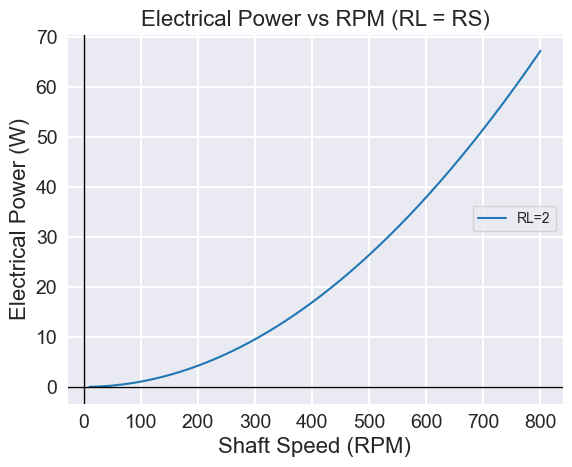

<Figure size 640x480 with 0 Axes>

In [14]:
# Define a range of RPM values
RPM_values = np.linspace(10, maxRPM, 1000)
RL_values = R_S

# Calculate P_el for each RPM value and each RL value
P_el_values = []

P_el_P = [getPowerRPM(RPM, RL_values,2) for RPM in RPM_values]
P_el_values.append(P_el_P)

# Save data as CSV (optional)
data = np.column_stack((RPM_values, *P_el_values))
# Set Seaborn style
sns.set_style("darkgrid")

plt.plot(RPM_values, P_el_P, label=f'RL={RL_values}')

plt.xlabel('Shaft Speed (RPM)',fontsize=16)
plt.ylabel('Electrical Power (W)',fontsize=16)
plt.title('Electrical Power vs RPM (RL = RS)',fontsize=16)
plt.legend()
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
# Increase the width of grid lines

plt.xticks(fontsize=14)  # Enlarge x-axis tick labels font size
plt.yticks(fontsize=14)  # Enlarge y-axis tick labels font size
plt.grid(True, linewidth=1.5)
plt.show()
plt.savefig('maxpwr_peak_rpm.png', dpi=300)  # Increase DPI for higher resolution

# Save data as CSV
data = np.column_stack((RPM_values, P_el_RMS))
np.savetxt('power_data_peak.csv', data, delimiter=',', header='RPM,Electrical Power', comments='')

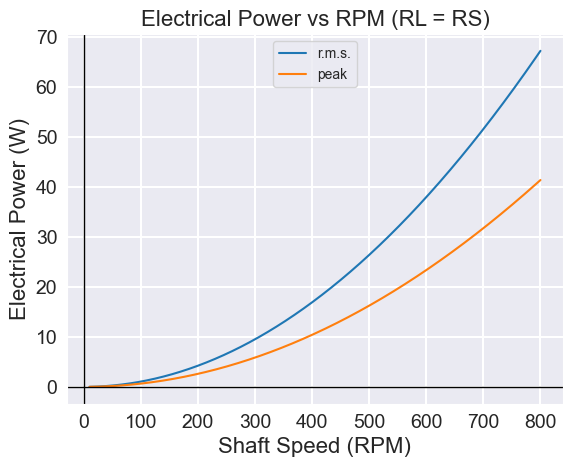

In [15]:
plt.plot(RPM_values, P_el_P, label='r.m.s.')
plt.plot(RPM_values, P_el_RMS, label='peak')

plt.xlabel('Shaft Speed (RPM)',fontsize=16)
plt.ylabel('Electrical Power (W)',fontsize=16)
plt.title('Electrical Power vs RPM (RL = RS)',fontsize=16)
plt.legend()
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
# Increase the width of grid lines

plt.xticks(fontsize=14)  # Enlarge x-axis tick labels font size
plt.yticks(fontsize=14)  # Enlarge y-axis tick labels font size
plt.grid(True, linewidth=1.5)
plt.show()

### Voltage - RPM 

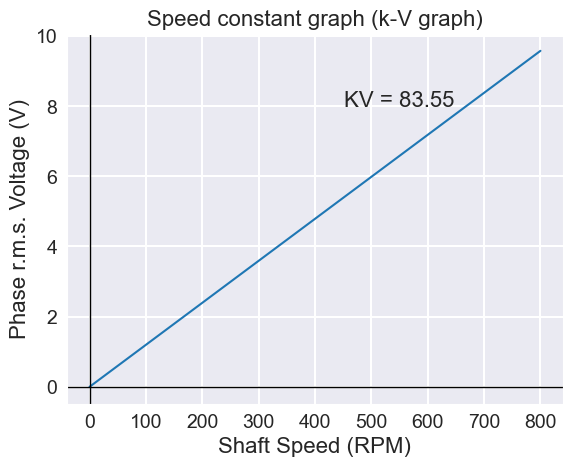

In [16]:
RPM_values = np.linspace(0, maxRPM, 1000)

EMF = [getEMFRPM(RPM) for RPM in RPM_values]

# Extract the real component of each complex number
EMF_real = np.real(EMF)

plt.plot(RPM_values, EMF_real)
plt.xlabel('Shaft Speed (RPM)',fontsize=16)
plt.ylabel('Phase r.m.s. Voltage (V)',fontsize=16)
plt.title('Speed constant graph (k-V graph)',fontsize=16)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
# Calculate and display the gradient for the first RPM value
grad_T = np.gradient(RPM_values, EMF_real)
grad_label = f'KV = {grad_T[-1]:.2f}'
plt.text(550, 8, grad_label, fontsize=16, ha='center')
plt.xticks(fontsize=14)  # Enlarge x-axis tick labels font size
plt.yticks(fontsize=14)  # Enlarge y-axis tick labels font size
plt.grid(True, linewidth=1.5)
plt.savefig('speedconst.png', dpi=300)  # Increase DPI for higher resolution

plt.show()


### Torque - Current Graph

C:\Users\Kai Wen Lee\AppData\Local\Temp\ipykernel_9092\2197645440.py:143: RuntimeWarning: invalid value encountered in divide
  T_em_AV = (3*(E_G_ph**2)*R_SL)/(RPM_2_angvel(RPM)*(R_SL**2+X_SL**2))


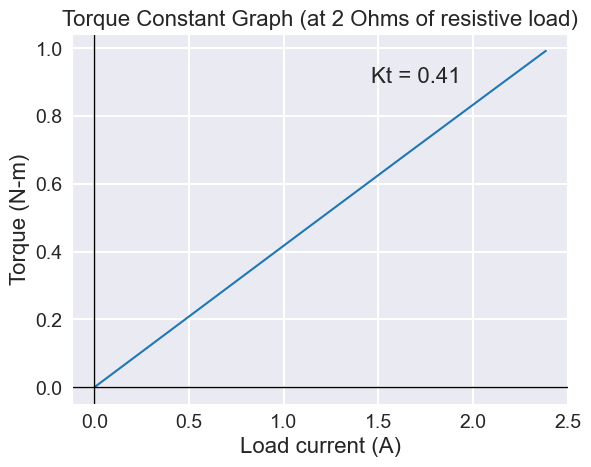

In [17]:
# Define a range of RPM values
R_values = np.linspace(1, 800, 1000)

# Calculate I_G and T_em_AV for each RPM value
I_G_values_all = []
T_em_AV_values_all = []
for RPM in RPM_values:
    I_G, T_em_AV = getTorqueCurrent(RPM)
    I_G_values_all.append(I_G)
    T_em_AV_values_all.append(T_em_AV)

# Set Seaborn style
sns.set_style("darkgrid")

# Plot I_G against T_em_AV
plt.plot(I_G_values_all,T_em_AV_values_all)
plt.ylabel('Torque (N-m)',fontsize=16)
plt.xlabel('Load current (A)',fontsize=16)
plt.title('Torque Constant Graph (at 2 Ohms of resistive load)',fontsize=16)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)

# Calculate and display the gradient for the first RPM value
grad_T = np.gradient(T_em_AV_values_all, I_G_values_all)
grad_label = f'Kt = {grad_T[-1]:.2f}'
plt.text(1.7, 0.9, grad_label, fontsize=16, ha='center')
plt.xticks(fontsize=14)  # Enlarge x-axis tick labels font size
plt.yticks(fontsize=14)  # Enlarge y-axis tick labels font size
plt.grid(True, linewidth=1.5)
plt.savefig('torque_vs_load_current.png', dpi=300)  # Increase DPI for higher resolution
plt.show()


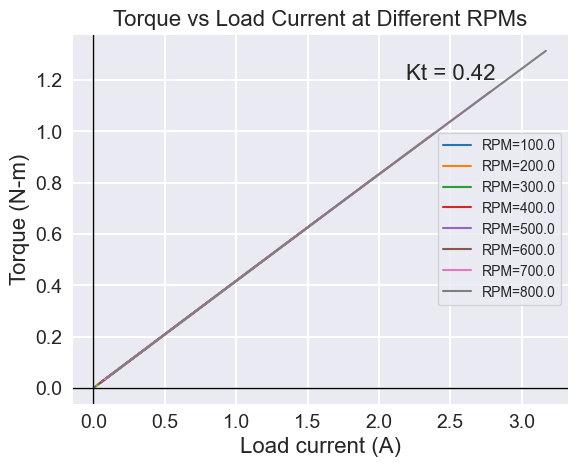

In [18]:
# Define a range of RPM values
R_values = np.linspace(1, 100, 50)
RPM_values = np.linspace(100, maxRPM, 8)

# Calculate T_em_AV and I_G for each RPM value and R value
all_I_G_values = []
all_T_em_AV_values = []

for RPM in RPM_values:
    I_G_values = []
    T_em_AV_values = []
    for R in R_values:
        I_G, T_em_AV = getTorqueCurrent(RPM, R_L=R)
        I_G_values.append(I_G)
        T_em_AV_values.append(T_em_AV)
    
    all_I_G_values.append(I_G_values)
    all_T_em_AV_values.append(T_em_AV_values)

# Set Seaborn style
sns.set_style("darkgrid")

# Plot T_em_AV against I_G for each RPM value
for i, RPM in enumerate(RPM_values):
    plt.plot(all_I_G_values[i], all_T_em_AV_values[i], label=f'RPM={RPM}')

plt.xlabel('Load current (A)',fontsize=16)
plt.ylabel('Torque (N-m)',fontsize=16)
plt.title('Torque vs Load Current at Different RPMs',fontsize=16)
plt.legend()
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)

# Calculate and display the gradient for the first RPM value
RPM = RPM_values[0]
grad_T = np.gradient(all_T_em_AV_values[0], all_I_G_values[0])
grad_label = f'Kt = {grad_T[-1]:.2f}'
plt.text(2.5, 1.2, grad_label, fontsize=16, ha='center')
plt.xticks(fontsize=14)  # Enlarge x-axis tick labels font size
plt.yticks(fontsize=14)  # Enlarge y-axis tick labels font size
plt.grid(True, linewidth=1.5)
plt.savefig('torque_vs_load_current_rpm.png', dpi=300)  # Increase DPI for higher resolution
plt.show()
